In [1]:
# Loading the Packages
%reload_ext autoreload
%autoreload 2

In [2]:
import os
from pathlib import Path
from tqdm import tqdm
from pprint import pprint
import pickle
import yaml
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import scanpy as sc

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({
    "pgf.texsystem": "xelatex",      # 使用 XeLaTeX，如果不需要 LaTeX 公式渲染，可以省略
    'font.family': 'serif',          # 字体设置为衬线字体
    'text.usetex': False,            # 禁用 LaTeX，使用 Matplotlib 内置文字渲染
    'pgf.rcfonts': False,            # 禁用 pgf 的默认字体管理
    'pdf.fonttype': 42,              # 确保字体为 TrueType 格式，可被 Illustrator 编辑
    'ps.fonttype': 42,               # EPS 文件也使用 TrueType 格式
    'figure.dpi': 300,               # 设置图形分辨率
    'savefig.dpi': 300,              # 保存的图形文件分辨率
    'axes.unicode_minus': False,     # 避免负号问题
})

In [3]:
# workdir 
BASE_DIR = Path(r'G:\spatial_data')
RUN_ID_LIST = []

# analysis dir
RUN_ID = '20250222_combined_analysis_of_pseudo_HCC3D'
analysis_dir = BASE_DIR / 'analysis' / RUN_ID
typ_path = analysis_dir / "cell_typing"

output_path = analysis_dir / "STAGATE"
output_path.mkdir(exist_ok=True)

# Module analysis

In [4]:
adata = sc.read_h5ad(output_path / 'adata_STAGATE_light.h5ad')

## mclust 10

In [16]:
cur_path = output_path / 'mclust_10'

### module cell type content and enrichment

In [20]:
column_order = [str(_) for _ in [1,3,4,5,9,6,2,8,10,7]]
STAGATE_params = yaml.load(open(analysis_dir / 'STAGATE_analysis_params.yaml', 'r'), Loader=yaml.FullLoader)
type_order = STAGATE_params['type_order']
subtype_order = STAGATE_params['subtype_order']

# 提取 mclust_annotated 和 type 列
mclust_type_counts = adata.obs.groupby(['mclust_10', 'type']).size().unstack(fill_value=0)
mclust_type_counts = mclust_type_counts.loc[column_order]
mclust_type_counts = mclust_type_counts[[_ for _ in mclust_type_counts.columns if _ not in ['other', 'unknown']]]
mclust_type_counts = mclust_type_counts[type_order]
# 计算每个 mclust 类别中 type 的均值（行归一化）
mclust_type_mean = mclust_type_counts.div(mclust_type_counts.sum(axis=1), axis=0)

mclust_subtype_counts = adata.obs.groupby(['mclust_10', 'subtype']).size().unstack(fill_value=0)
mclust_subtype_counts = mclust_subtype_counts.loc[column_order]
mclust_subtype_counts = mclust_subtype_counts[[_ for _ in mclust_subtype_counts.columns if _ not in ['other', 'unknown']]]
mclust_subtype_counts = mclust_subtype_counts[subtype_order]
# 计算每个 mclust 类别中 type 的均值（行归一化）
mclust_subtype_mean = mclust_subtype_counts.div(mclust_subtype_counts.sum(axis=1), axis=0)

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 12))
# type
ax1 = axes[0]
sns.heatmap(
    mclust_type_mean, cmap='coolwarm', annot=True, fmt='.2f', 
    linewidths=0.5, square=True, vmax=0.2, cbar_kws={'label': 'Proportion of Cells'}, ax=ax1)
ax1.set_title('Mean Proportion of Cell Types per mclust_annotated')
ax1.set_xlabel('Cell Type (type)')
ax1.set_ylabel('Spatial Cluster (mclust_annotated)')
# subtype
ax2 = axes[1]
sns.heatmap(
    mclust_subtype_mean, cmap='coolwarm', # annot=True,
    fmt='.2f', linewidths=0.5, square=True, vmax=0.1, cbar_kws={'label': 'Proportion of Cells'})
ax2.set_title('Mean Proportion of Cell Subtypes per mclust_annotated')
ax2.set_xlabel('Cell Type (type)')
ax2.set_ylabel('Spatial Cluster (mclust_annotated)')
plt.savefig(cur_path / 'module_celltype_content.pdf')
plt.close()

In [30]:
# 计算 Ro/e
def roe_cal(df1, df2):
    # 提取 mclust_annotated 和 type 的观察值
    observed = pd.crosstab(df1, df2)
    # 计算期望值（基于全局比例）
    total_cells = observed.sum().sum()  # 总细胞数
    type_proportions = observed.sum(axis=0) / total_cells  # 每个 type 的全局比例
    mclust_totals = observed.sum(axis=1)  # 每个 mclust 的总细胞数
    # 计算期望值矩阵
    expected = pd.DataFrame(np.outer(mclust_totals, type_proportions), index=observed.index, columns=observed.columns)
    # 计算 Ro/e 并避免除以零
    roe = observed / expected.replace(0, 1e-10)
    return roe, expected, observed
# visualize Ro/e
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(28, 18))
# type
ax1 = axes[0]
roe_type, expected_type, observed_type = roe_cal(adata.obs["mclust_10"], adata.obs["type"])
roe_type = roe_type.loc[column_order, type_order]
observed_type = observed_type.loc[column_order, type_order]
sns.heatmap(
    np.log2(roe_type), 
    cmap="coolwarm", center=0, # 以 log2(1)=0 为中心（无富集）
    annot=observed_type, # 标注原始观察值
    vmax=2.5, vmin=-2.5, fmt="d", # 观察值为整数
    linewidths=1, cbar_kws={"label": "log2(Ro/e)"}, ax=ax1)
ax1.set_title("Cell Type Enrichment (Ro/e) by mclust_10")
ax1.set_xlabel("Cell Type (type)")
ax1.set_ylabel("Spatial Cluster (mclust_10)")
# subtype
ax2 = axes[1]
roe_subtype, expected_subtype, observed_subtype = roe_cal(adata.obs["mclust_10"], adata.obs["subtype"])
roe_subtype = roe_subtype.loc[column_order, subtype_order]
observed_subtype = observed_subtype.loc[column_order, subtype_order]
sns.heatmap(
    np.log2(roe_subtype), cmap="coolwarm", center=0, # 以 log2(1)=0 为中心（无富集）
    # annot=observed_subtype, # 标注原始观察值
    vmax=2.5, vmin=-2.5, fmt="d", # 观察值为整数
    linewidths=3, cbar_kws={"label": "log2(Ro/e)"}, ax=ax2)
ax2.set_title("Cell Type Enrichment (Ro/e) by mclust_10")
ax2.set_xlabel("Cell SubType (type)")
ax2.set_ylabel("Spatial Cluster (mclust_10)")
plt.savefig(cur_path / 'module_celltype_ROE.pdf')
plt.close()

### corr between mclust or cell types

In [22]:
mclust_subtype_mean_corr = mclust_subtype_mean.copy()
STAGATE_params = yaml.load(open(analysis_dir / 'STAGATE_analysis_params.yaml', 'r'), Loader=yaml.FullLoader)
annotation_name = STAGATE_params['STAGATE_mclust_10_annotate']
mclust_subtype_mean_corr.index = mclust_subtype_mean_corr.index.map(annotation_name)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

method = 'ward'
# 生成示例数据（假设 mclust_subtype_mean 是基因表达矩阵）
corr_matrix = mclust_subtype_mean_corr.corr()

# 使用 clustermap 自动绘制带层次聚类的热图
g = sns.clustermap(corr_matrix, cmap='coolwarm', method=method,  # 聚类方法
                   metric='euclidean',  # 距离度量
                   figsize=(10, 10), dendrogram_ratio=0.2,  # 树状图比例
                   cbar_pos=(0.02, 0.8, 0.05, 0.18))  # 调整色带位置

# 自定义美化参数
g.ax_heatmap.set_xlabel("Features", fontsize=12)
g.ax_heatmap.set_ylabel("Subtypes", fontsize=12)
g.ax_row_dendrogram.set_visible(True)  # 显示行树状图
g.ax_col_dendrogram.set_visible(True)  # 显示列树状图

# 手动添加树状图切割线示例（切割为3类）
dendro = linkage(corr_matrix, method=method)
dendrogram(dendro, color_threshold=0.7, ax=g.ax_row_dendrogram)
plt.savefig(cur_path / 'corr_mclust.pdf')
plt.close()

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram

method = 'ward'
# 生成示例数据（假设 mclust_subtype_mean 是基因表达矩阵）
corr_matrix = mclust_subtype_mean_corr.T.corr()

# 使用 clustermap 自动绘制带层次聚类的热图
g = sns.clustermap(corr_matrix, cmap='coolwarm',
                   method=method, metric='euclidean',  # 距离度量
                   figsize=(10, 10), dendrogram_ratio=0.2,  # 树状图比例
                   cbar_pos=(0.02, 0.8, 0.05, 0.18))  # 调整色带位置

# 自定义美化参数
g.ax_heatmap.set_xlabel("Features", fontsize=12)
g.ax_heatmap.set_ylabel("Subtypes", fontsize=12)
g.ax_row_dendrogram.set_visible(True)  # 显示行树状图
g.ax_col_dendrogram.set_visible(True)  # 显示列树状图

# 手动添加树状图切割线示例（切割为3类）
dendro = linkage(corr_matrix, method=method)
dendrogram(dendro, color_threshold=0.7, ax=g.ax_row_dendrogram)
plt.savefig(cur_path / 'corr_celltype.pdf')
plt.close()

### define region for viz

In [ ]:
with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
STAGATE_annotate = STAGATE_params['STAGATE_mclust_10_annotate_viz']
pprint(STAGATE_annotate, sort_dicts=False)
map_dict = {str(mclust): str(num+1) for num, (key, mclust_list) in enumerate(STAGATE_annotate.items()) for mclust in mclust_list}
adata.obs['mclust_10_annotated'] = adata.obs['mclust_10'].astype(str).map(map_dict).astype(str)

## mclust 11

### Cell composition

In [ ]:
import yaml

with open(os.path.join(analysis_dir, 'cell_typing_params.yaml'), 'r') as f:
    annotaiton_params = yaml.load(f, Loader=yaml.FullLoader)
print(annotaiton_params.keys())

In [ ]:
leiden_annotation = annotaiton_params['leiden_annotation']
leiden_type_dict = {}
leiden_subtype_dict = {}
for type_key, subtypes in leiden_annotation.items():
    type_values = []
    for subtype_key, values in subtypes.items():
        type_values.extend(values)
        leiden_subtype_dict[subtype_key] = values
    leiden_type_dict[type_key] = type_values

type_colormap = annotaiton_params['type_colormap']
subtype_colormap = dict()
for subtype in leiden_subtype_dict.keys():
    for rough_type in type_colormap.keys():
        if rough_type in subtype:
            subtype_colormap[subtype] = type_colormap[rough_type]
            break
# subtype_colormap

In [ ]:
subtype_colormap['Tumor_AFP+'] = [1, 0.5, 0]
subtype_colormap['Tumor_AFP+'] = [1, 0.5, 0]
subtype_colormap['Tumor_GPC3+'] = [0.75, 0.5, 0.5]
subtype_colormap['Tumor_proliferation'] = [1, 0.5, 0]

subtype_colormap['B_CD79A+, MS4A1+'] = [0, 0.5, 0.5]
subtype_colormap['cDC2_CD1C+'] = [1, 0.6, 0]
subtype_colormap['Macrophage_C1QA+'] = [0, 0.8, 0.5]
subtype_colormap['Mait_SLC4A10+'] = [0, 0, 1]
subtype_colormap['Neutrophil_CSF3R+'] = [0.5, 0.5, 0]
subtype_colormap['T_CD4+, CXCL13+'] = [0.8,0.8,0.8]
subtype_colormap['T_CD4+, PD1+, CTLA4+'] = [0.8,0.8,0.8]
subtype_colormap['T_CD8+, GZMA+, CXCL13+'] = [1,0,0]
subtype_colormap['Monocyte_CD14+, CD16+'] = [0,0.8,1]

In [ ]:
non_immune_subtype = ['Liver', 'Tumor_AFP+', 'Tumor_GPC3+', 'Tumor_proliferation', 'other_cell_proliferation', 'Endo_PECAM1+', 'Ep_EPCAM+', 'CAF_ACTA2+',]
immune_subtype = [_ for _ in subtype_colormap.keys() if _ not in non_immune_subtype]

In [ ]:
cluster_num = 11
immune_data = adata[adata.obs.subtype.isin(immune_subtype)]
non_immune_data = adata[adata.obs.subtype.isin(non_immune_subtype)]

def plot_stacked_bar(data, subtype_list, mclust_order, title, colormap, ax):
    # 根据mclust_13聚类列统计每个聚类内不同细胞类型的数量
    subtype_counts = data.groupby([f'mclust_{cluster_num}', 'subtype']).size().unstack(fill_value=0)
    subtype_counts = subtype_counts.loc[mclust_order]
    subtype_counts = subtype_counts.loc[:, subtype_counts.columns.isin(subtype_list)]    
    subtype_counts_normalized = subtype_counts.div(subtype_counts.sum(axis=1), axis=0)
    colors = [colormap[subtype] for subtype in subtype_counts_normalized.columns]    
    
    # 绘制堆叠条形图，并禁用自动图例
    subtype_counts_normalized.plot(kind='bar', stacked=True, ax=ax, color=colors, width=1.0, legend=False)
    
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Normalized Proportion')
    
    # 获取句柄和标签，并反转顺序
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=100)
mclust_order = [str(_) for _ in [1, 3, 4, 10, 9, 5, 11, 2, 6, 8, 7]]
# mclust_order = [str(_) for _ in range(1, cluster_num+1)]
plot_stacked_bar(immune_data.obs, immune_subtype, mclust_order, 'Immune Subtypes', subtype_colormap, axes[0])
plot_stacked_bar(non_immune_data.obs, non_immune_subtype, mclust_order, 'Non-Immune Subtypes', subtype_colormap, axes[1])
plt.tight_layout()
# plt.savefig(output_path / f'mClust{cluster_num}_subtype_distribution.png')
# plt.close()
plt.show()

In [ ]:
immune_data = adata[adata.obs.subtype.isin(immune_subtype)]
non_immune_data = adata[adata.obs.subtype.isin(non_immune_subtype)]

def plot_stacked_bar(data, title, colors, ax):
    subtype_counts = data.groupby([f'mclust_{cluster_num}', 'subtype_group']).size().unstack(fill_value=0)    
    subtype_counts_normalized = subtype_counts
    # subtype_counts_normalized = subtype_counts.div(subtype_counts.sum(axis=1), axis=0)
    
    subtype_counts_normalized.plot(kind='bar', stacked=True, ax=ax, color=colors, width=1.0)
    ax.set_title(title)
    ax.set_xlabel('Cluster')
    ax.set_ylabel('Normalized Proportion')
    ax.legend(title='Cell Type', bbox_to_anchor=(1.05, 1), loc='upper left')


fig, ax = plt.subplots(figsize=(8, 6), dpi=100)
colors = ['red', 'blue']
combined_data = pd.concat([immune_data.obs, non_immune_data.obs])
combined_data['subtype_group'] = combined_data['subtype'].apply(lambda x: 'immune' if x in immune_subtype else ('non-immune' if x in non_immune_subtype else 'other'))
plot_stacked_bar(combined_data, 'Immune vs Non-Immune Subtypes', colors, ax)

plt.tight_layout()
# plt.savefig(output_path / f'mClust{cluster_num}_im_non_im_cell_num.png')
# plt.close()
plt.show()

### define region based on cell composition and gene expression

In [ ]:
with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
STAGATE_annotate = STAGATE_params['STAGATE_mclust_11_annotate']
pprint(STAGATE_annotate, sort_dicts=False)
map_dict = {str(mclust): str(num+1) for num, (key, mclust_list) in enumerate(STAGATE_annotate.items()) for mclust in mclust_list}
adata.obs['mclust_annotated'] = adata.obs['mclust_11'].astype(str).map(map_dict).astype(str)

In [ ]:
adata.write_h5ad(output_path / 'adata_STAGATE_annotated.h5ad')

### detailed module analysis

In [ ]:
column_order = [str(_) for _ in [1,3,4,10,11,5,9,2,6,8,7]]

with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
type_order = STAGATE_params['type_order']
subtype_order = STAGATE_params['subtype_order']

In [ ]:
# 提取 mclust_annotated 和 type 列
mclust_type_counts = adata.obs.groupby(['mclust_11', 'type']).size().unstack(fill_value=0)
mclust_type_counts = mclust_type_counts.loc[column_order]
mclust_type_counts = mclust_type_counts[[_ for _ in mclust_type_counts.columns if _ not in ['other', 'unknown']]]
mclust_type_counts = mclust_type_counts[type_order]
# 计算每个 mclust 类别中 type 的均值（行归一化）
mclust_type_mean = mclust_type_counts.div(mclust_type_counts.sum(axis=1), axis=0)

mclust_subtype_counts = adata.obs.groupby(['mclust_11', 'subtype']).size().unstack(fill_value=0)
mclust_subtype_counts = mclust_subtype_counts.loc[column_order]
mclust_subtype_counts = mclust_subtype_counts[[_ for _ in mclust_subtype_counts.columns if _ not in ['other', 'unknown']]]
mclust_subtype_counts = mclust_subtype_counts[subtype_order]
# 计算每个 mclust 类别中 type 的均值（行归一化）
mclust_subtype_mean = mclust_subtype_counts.div(mclust_subtype_counts.sum(axis=1), axis=0)

In [ ]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 12))
# type
ax1 = axes[0]
sns.heatmap(
    mclust_type_mean,
    cmap='coolwarm',
    annot=True,
    fmt='.2f',
    linewidths=0.5,
    square=True,
    vmax=0.2,
    cbar_kws={'label': 'Proportion of Cells'},
    ax=ax1,
)
ax1.set_title('Mean Proportion of Cell Types per mclust_annotated')
ax1.set_xlabel('Cell Type (type)')
ax1.set_ylabel('Spatial Cluster (mclust_annotated)')

# subtype
ax2 = axes[1]
sns.heatmap(
    mclust_subtype_mean,
    cmap='coolwarm',
    # annot=True,
    fmt='.2f',
    linewidths=0.5,
    square=True,
    vmax=0.1,
    cbar_kws={'label': 'Proportion of Cells'}
)
ax2.set_title('Mean Proportion of Cell Subtypes per mclust_annotated')
ax2.set_xlabel('Cell Type (type)')
ax2.set_ylabel('Spatial Cluster (mclust_annotated)')
plt.show()

In [ ]:
def roe_cal(df1, df2):
    # 提取 mclust_annotated 和 type 的观察值
    observed = pd.crosstab(df1, df2)

    # 计算期望值（基于全局比例）
    total_cells = observed.sum().sum()  # 总细胞数
    type_proportions = observed.sum(axis=0) / total_cells  # 每个 type 的全局比例
    mclust_totals = observed.sum(axis=1)  # 每个 mclust 的总细胞数

    # 计算期望值矩阵
    expected = pd.DataFrame(
        np.outer(mclust_totals, type_proportions),
        index=observed.index, columns=observed.columns)

    # 计算 Ro/e 并避免除以零
    roe = observed / expected.replace(0, 1e-10)
    return roe, expected, observed

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(28, 18))
ax1 = axes[0]
roe_type, expected_type, observed_type = roe_cal(adata.obs["mclust_11"], adata.obs["type"])

roe_type = roe_type.loc[column_order, type_order]
observed_type = observed_type.loc[column_order, type_order]
sns.heatmap(
    np.log2(roe_type),
    cmap="coolwarm",
    center=0,       # 以 log2(1)=0 为中心（无富集）
    annot=observed_type, # 标注原始观察值
    vmax=2,
    vmin=-2,
    fmt="d",        # 观察值为整数
    linewidths=0.5,
    cbar_kws={"label": "log2(Ro/e)"},
    ax=ax1, 
)
ax1.set_title("Cell Type Enrichment (Ro/e) by mclust_11")
ax1.set_xlabel("Cell Type (type)")
ax1.set_ylabel("Spatial Cluster (mclust_11)")

ax2 = axes[1]
roe_subtype, expected_subtype, observed_subtype = roe_cal(adata.obs["mclust_11"], adata.obs["subtype"])
roe_subtype = roe_subtype.loc[column_order, subtype_order]
observed_subtype = observed_subtype.loc[column_order, subtype_order]
sns.heatmap(
    np.log2(roe_subtype),
    cmap="coolwarm",
    center=0,       # 以 log2(1)=0 为中心（无富集）
    annot=observed_subtype, # 标注原始观察值
    vmax=2,
    vmin=-2,
    fmt="d",        # 观察值为整数
    linewidths=0.5,
    cbar_kws={"label": "log2(Ro/e)"},
    ax=ax2, 
)
ax2.set_title("Cell Type Enrichment (Ro/e) by mclust_11")
ax2.set_xlabel("Cell SubType (type)")
ax2.set_ylabel("Spatial Cluster (mclust_11)")

plt.show()

## mclust 30

In [8]:
key = 'mclust_30'
tmp_output_path = output_path / key
tmp_output_path.mkdir(exist_ok=True)

### define region based on cell composition and gene expression

In [ ]:
with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
STAGATE_annotate = STAGATE_params[f'STAGATE_{key}_annotate']
pprint(STAGATE_annotate, sort_dicts=False)
map_dict = {str(mclust): str(num+1) for num, (key, mclust_list) in enumerate(STAGATE_annotate.items()) for mclust in mclust_list}
adata.obs['mclust_annotated'] = adata.obs[key].astype(str).map(map_dict).astype(str)

### correlation between clusters

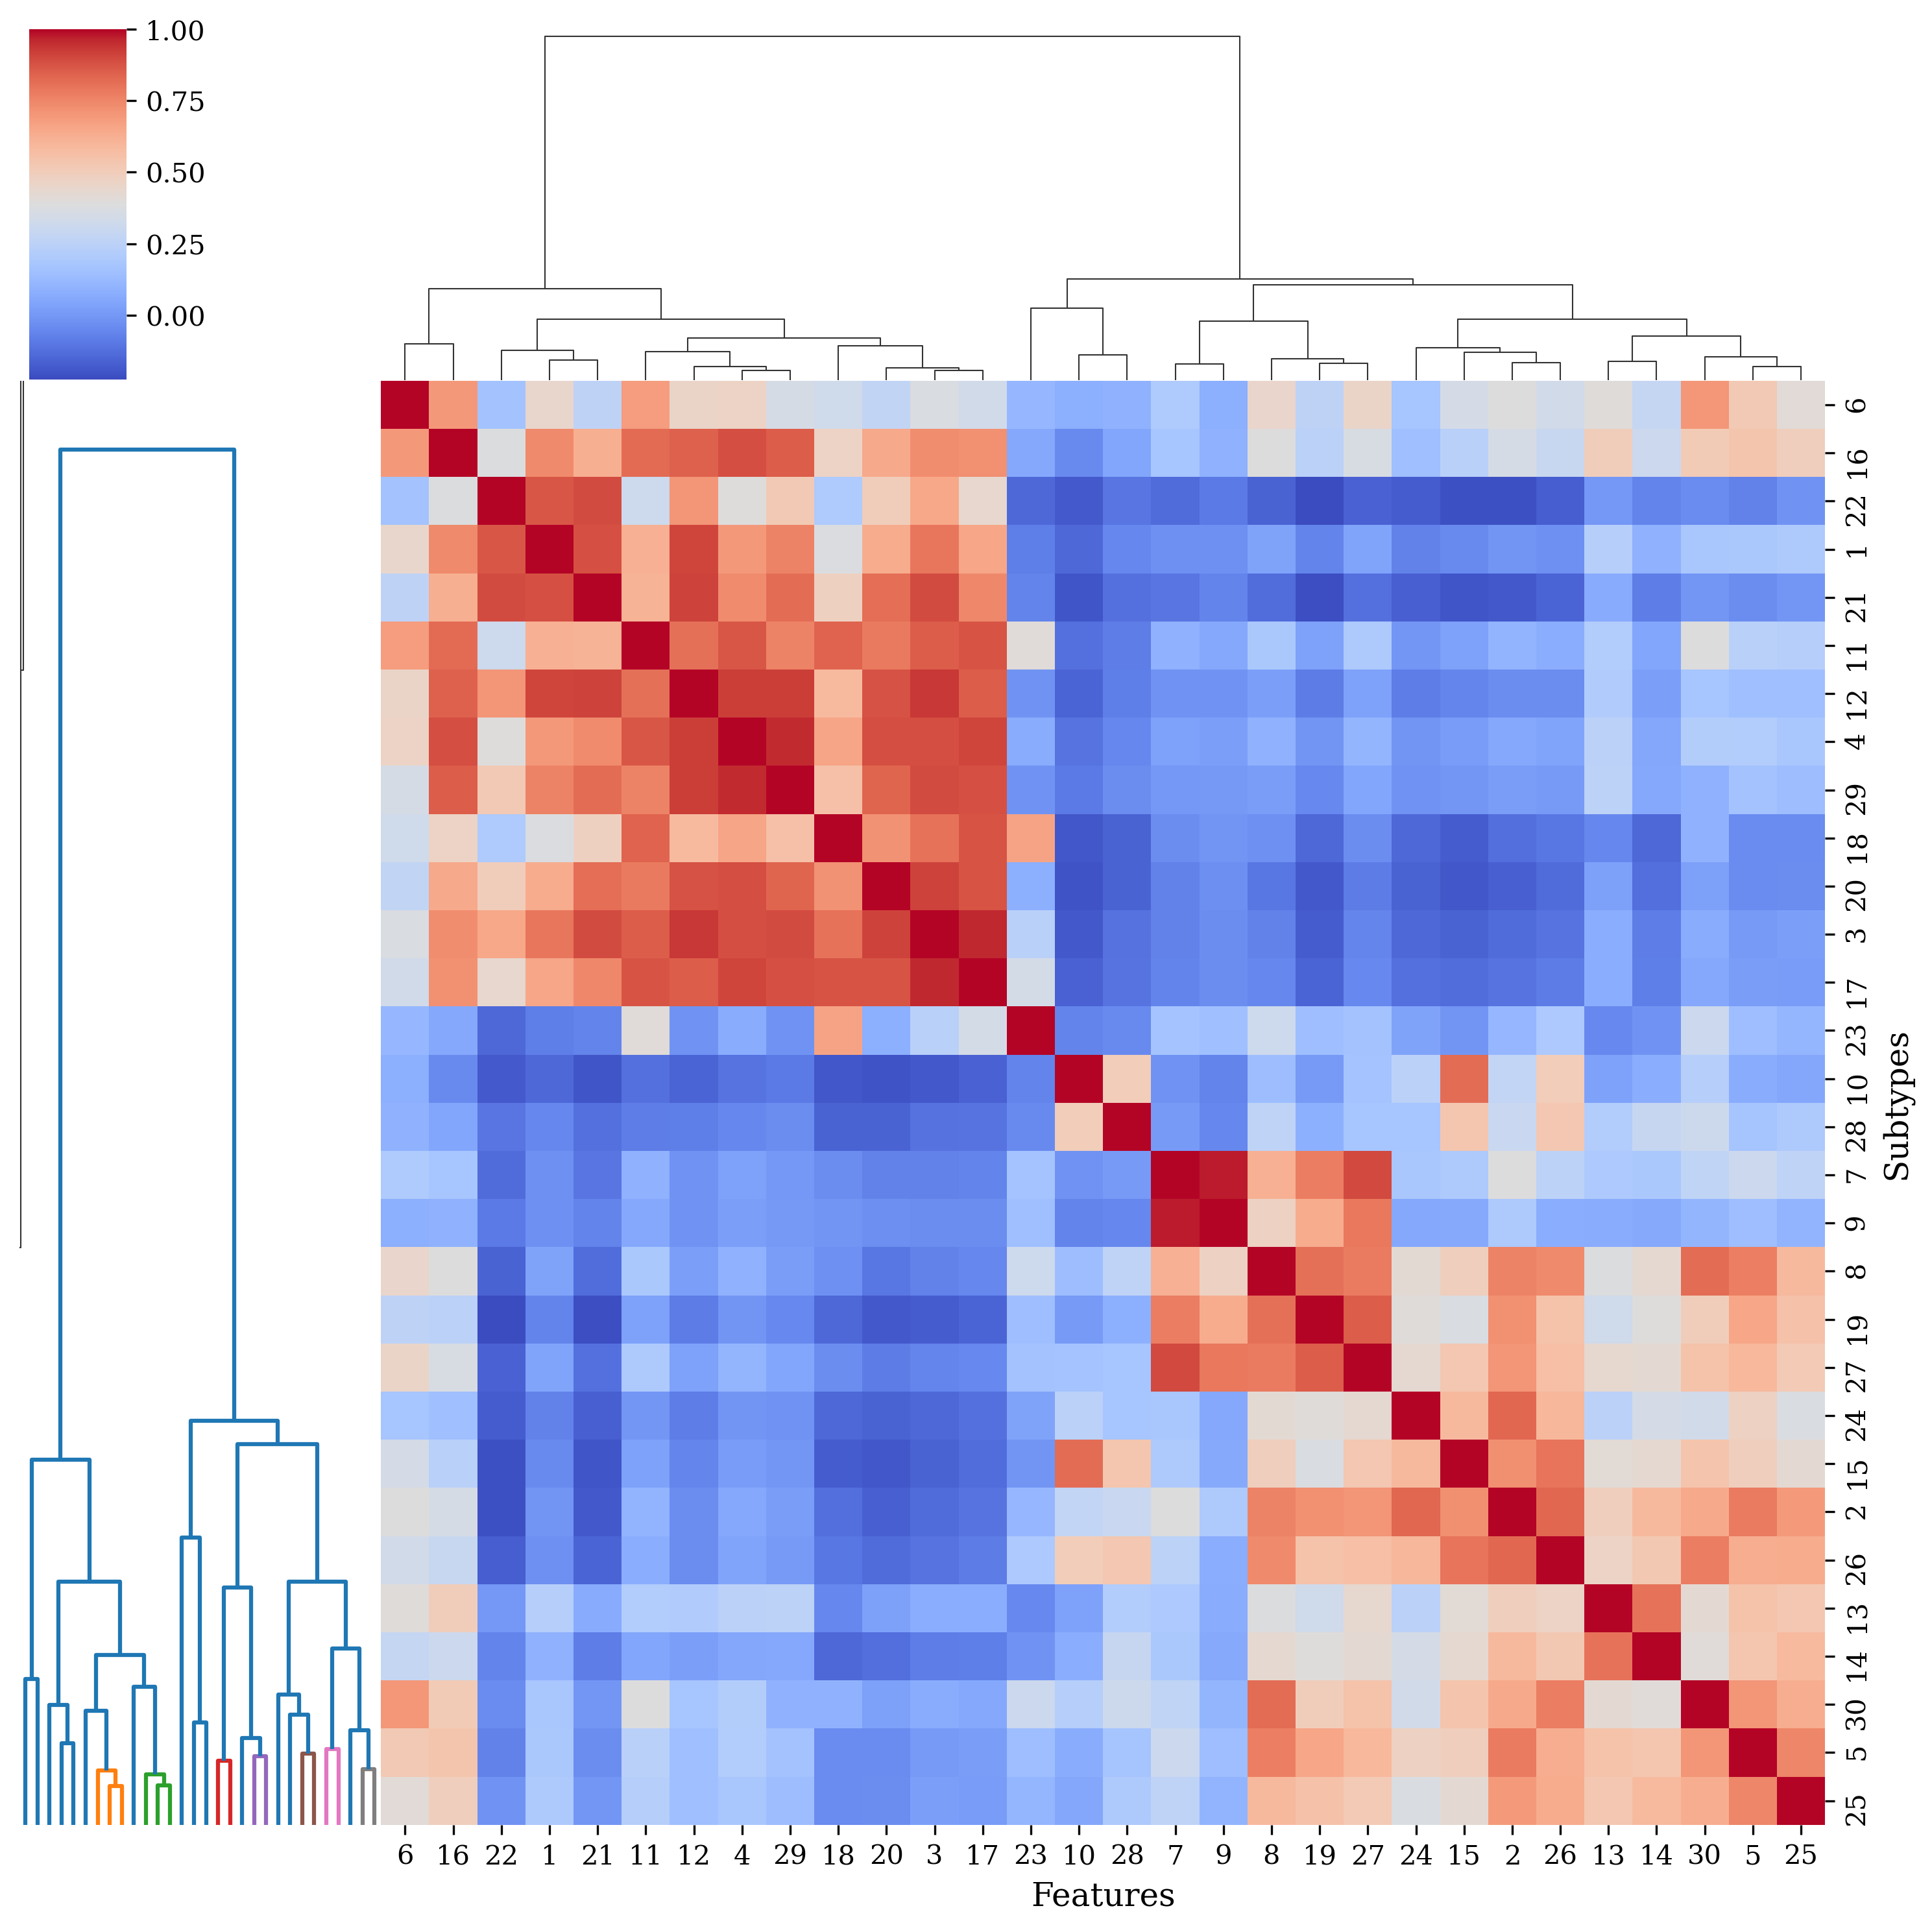

In [35]:
from scipy.cluster.hierarchy import linkage, dendrogram

mclust_subtype_mean_corr = mclust_subtype_mean.copy()
corr_matrix = mclust_subtype_mean_corr.T.corr()

# plt.figure(dpi=50)
# 使用 clustermap 自动绘制带层次聚类的热图
g = sns.clustermap(corr_matrix,
                   cmap='coolwarm',
                   method='ward',  # 聚类方法
                   metric='euclidean',  # 距离度量
                   figsize=(10, 10),
                   dendrogram_ratio=0.2,  # 树状图比例
                   cbar_pos=(0.02, 0.8, 0.05, 0.18))  # 调整色带位置

# 自定义美化参数
g.ax_heatmap.set_xlabel("Features", fontsize=12)
g.ax_heatmap.set_ylabel("Subtypes", fontsize=12)
g.ax_row_dendrogram.set_visible(True)  # 显示行树状图
g.ax_col_dendrogram.set_visible(True)  # 显示列树状图

# 手动添加树状图切割线示例（切割为3类）
dendro = linkage(corr_matrix, method='ward')
dendrogram(dendro, color_threshold=0.7, ax=g.ax_row_dendrogram)
plt.show()

### cell type percentage and roe

In [24]:
with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
type_order = STAGATE_params['type_order']
subtype_order = STAGATE_params['subtype_order']
column_order = [list(corr_matrix.index)[_] for _ in g.dendrogram_row.reordered_ind]

# type
mclust_type_counts = adata.obs.groupby([key, 'type']).size().unstack(fill_value=0)
mclust_type_counts = mclust_type_counts.loc[column_order]
mclust_type_counts = mclust_type_counts[[_ for _ in mclust_type_counts.columns if _ not in ['other', 'unknown']]]
mclust_type_counts = mclust_type_counts[type_order]
mclust_type_mean = mclust_type_counts.div(mclust_type_counts.sum(axis=1), axis=0)

# subtype
mclust_subtype_counts = adata.obs.groupby([key, 'subtype']).size().unstack(fill_value=0)
mclust_subtype_counts = mclust_subtype_counts.loc[column_order]
mclust_subtype_counts = mclust_subtype_counts[[_ for _ in mclust_subtype_counts.columns if _ not in ['other', 'unknown']]]
mclust_subtype_counts = mclust_subtype_counts[subtype_order]
mclust_subtype_mean = mclust_subtype_counts.div(mclust_subtype_counts.sum(axis=1), axis=0)

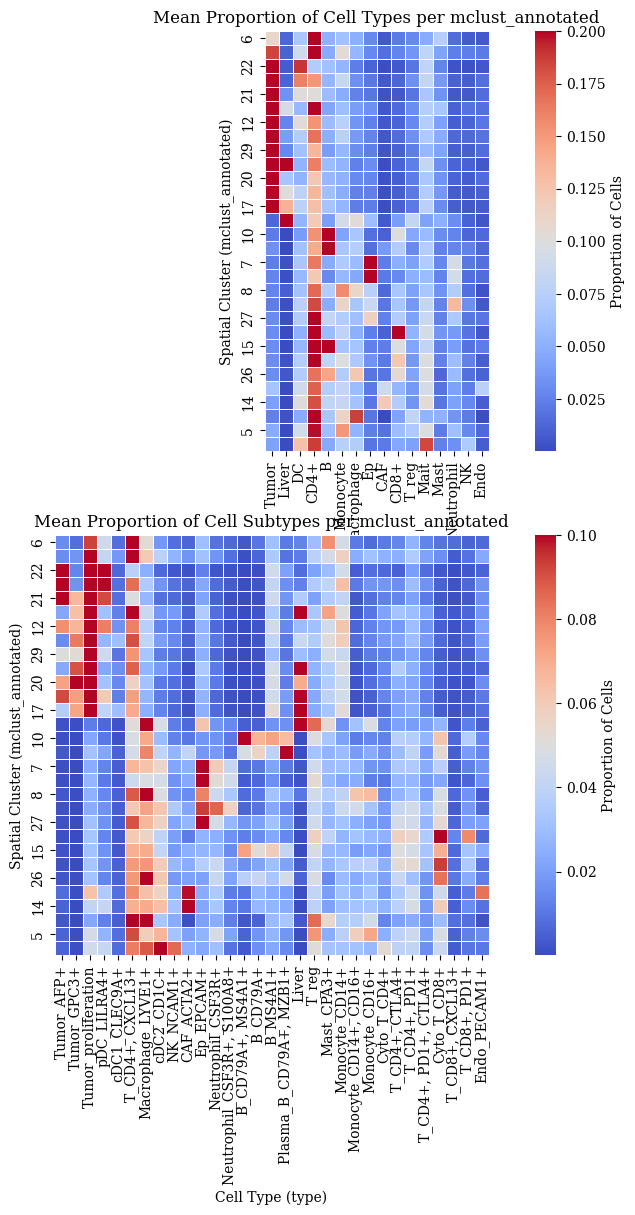

In [36]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 12), dpi=100)
# type
ax1 = axes[0]
sns.heatmap(mclust_type_mean, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, vmax=0.2, 
            cbar_kws={'label': 'Proportion of Cells'}, ax=ax1)
ax1.set_title('Mean Proportion of Cell Types per mclust_annotated')
ax1.set_xlabel('Cell Type (type)')
ax1.set_ylabel('Spatial Cluster (mclust_annotated)')

# subtype
ax2 = axes[1]
sns.heatmap(# annot=True, 
    mclust_subtype_mean, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, vmax=0.1,
    cbar_kws={'label': 'Proportion of Cells'}, ax=ax2)
ax2.set_title('Mean Proportion of Cell Subtypes per mclust_annotated')
ax2.set_xlabel('Cell Type (type)')
ax2.set_ylabel('Spatial Cluster (mclust_annotated)')
# plt.savefig(tmp_output_path / 'mclust_annotated_type_subtype.pdf')
# plt.close()
plt.show()

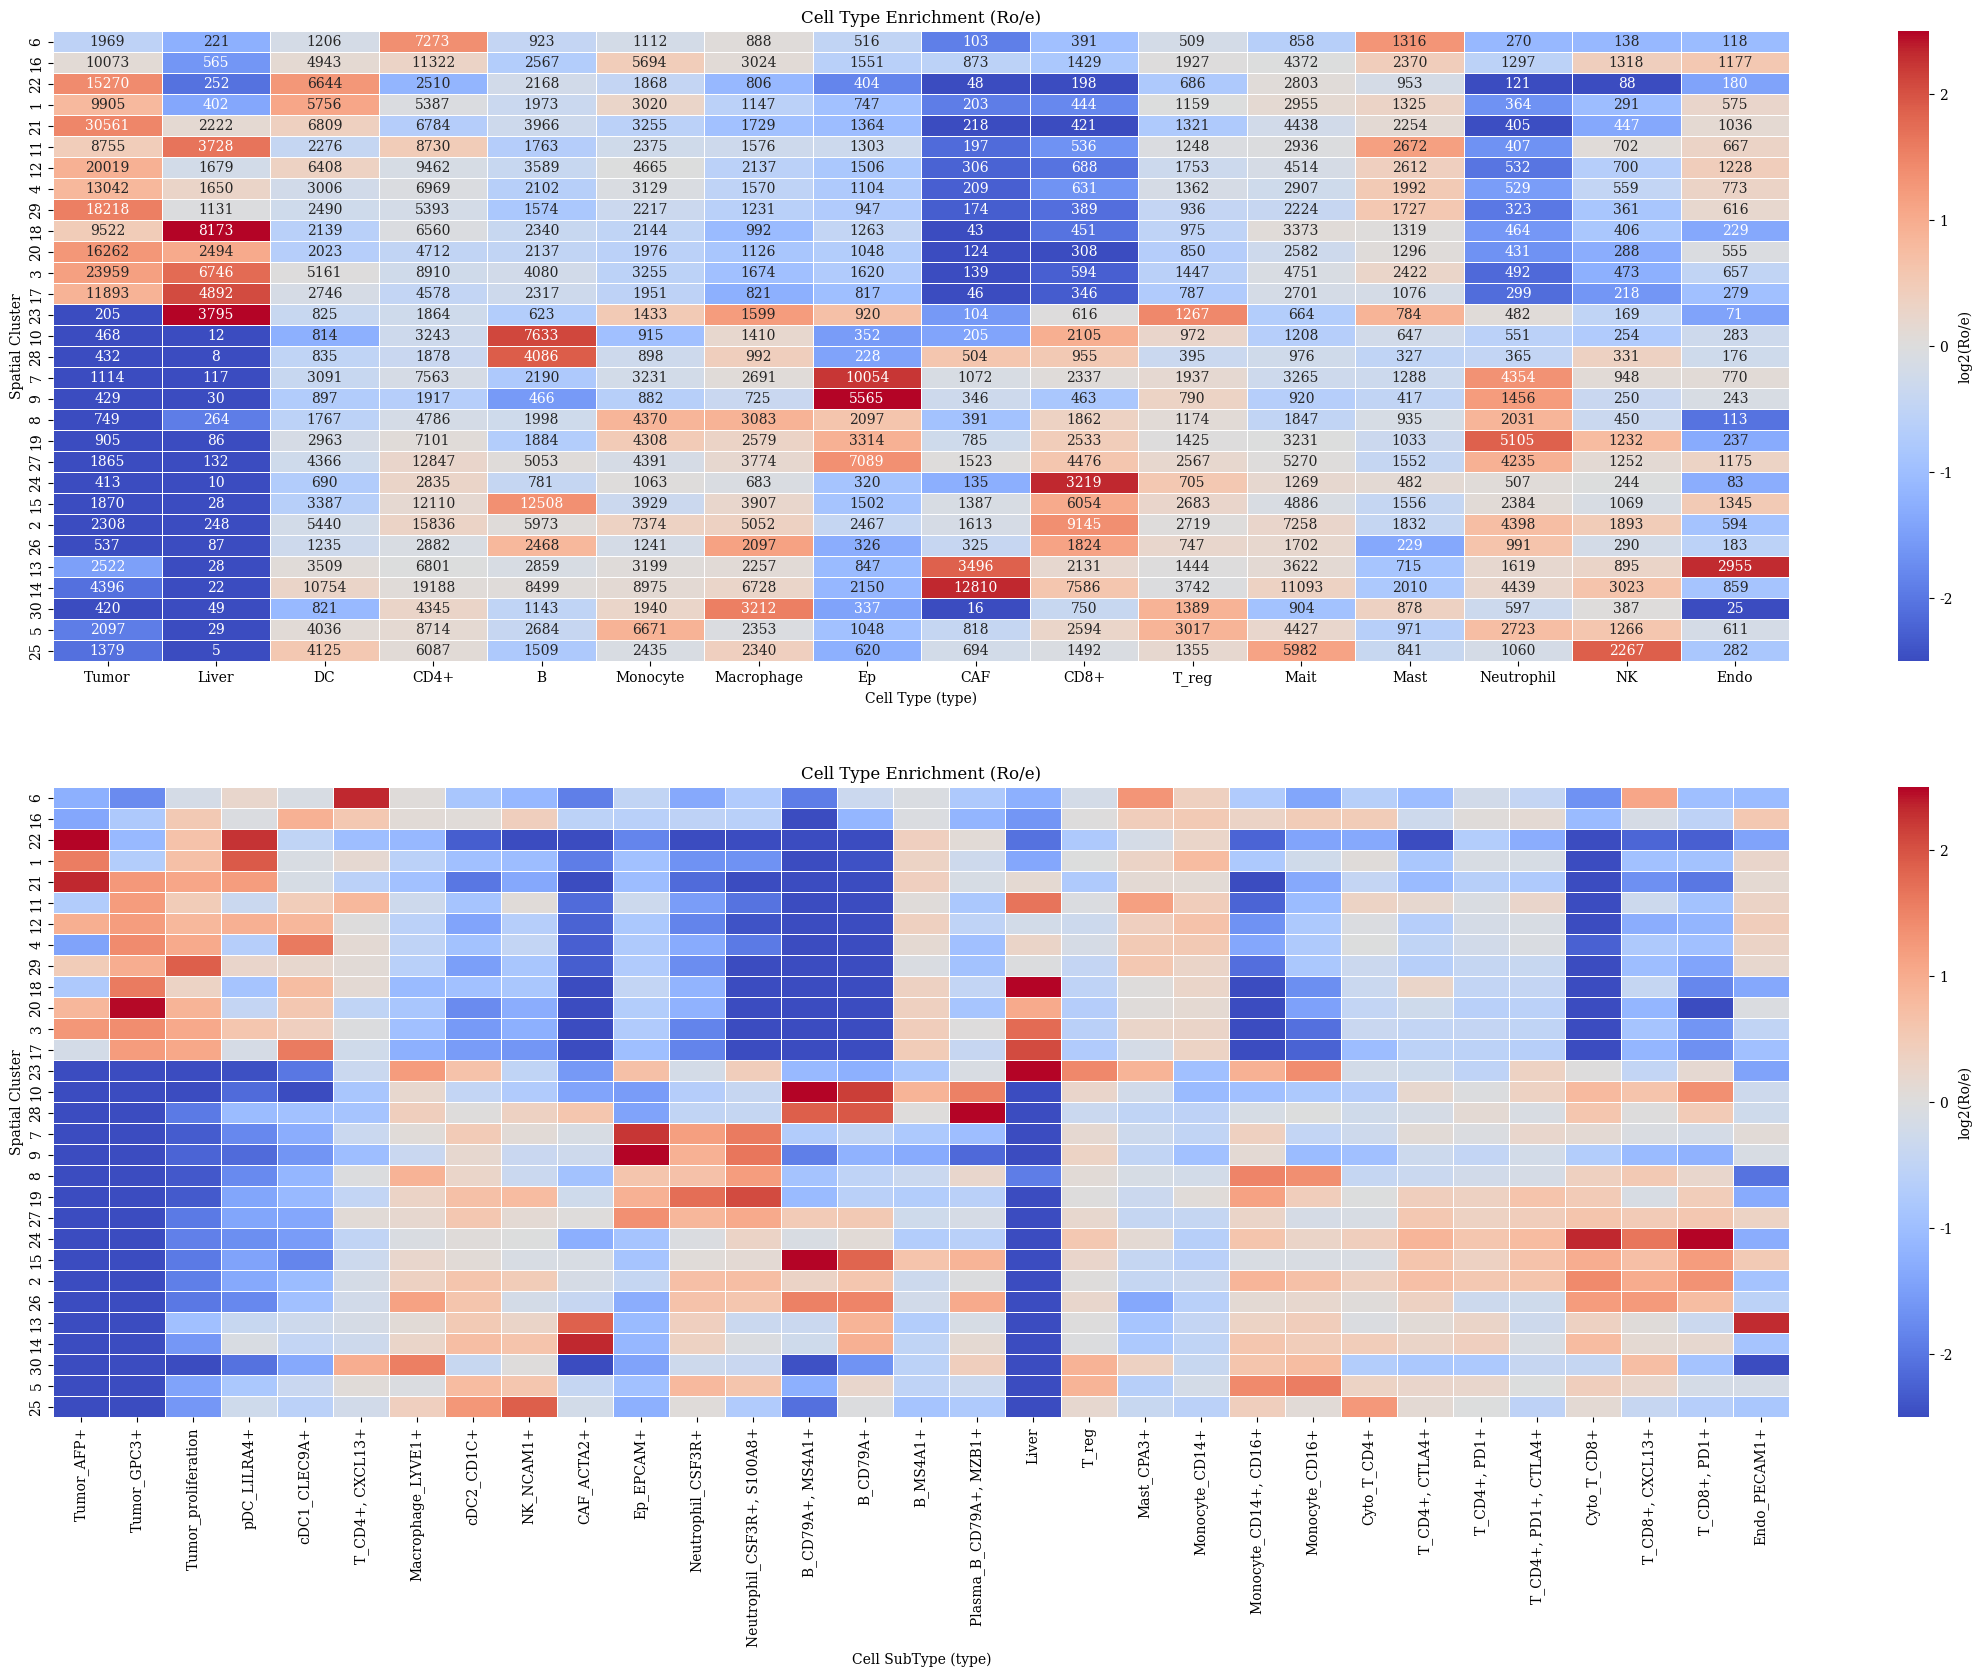

In [39]:
def roe_cal(df1, df2):
    # 提取 mclust_annotated 和 type 的观察值
    observed = pd.crosstab(df1, df2)

    # 计算期望值（基于全局比例）
    total_cells = observed.sum().sum()  # 总细胞数
    type_proportions = observed.sum(axis=0) / total_cells  # 每个 type 的全局比例
    mclust_totals = observed.sum(axis=1)  # 每个 mclust 的总细胞数

    # 计算期望值矩阵
    expected = pd.DataFrame(
        np.outer(mclust_totals, type_proportions),
        index=observed.index, columns=observed.columns)

    # 计算 Ro/e 并避免除以零
    roe = observed / expected.replace(0, 1e-10)
    return roe, expected, observed

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(28, 18), dpi=100)
ax1 = axes[0]
roe_type, expected_type, observed_type = roe_cal(adata.obs[key], adata.obs["type"])

roe_type = roe_type.loc[column_order, type_order]
observed_type = observed_type.loc[column_order, type_order]
sns.heatmap(
    np.log2(roe_type), cmap="coolwarm", center=0, # 以 log2(1)=0 为中心（无富集）
    annot=observed_type, # 标注原始观察值
    vmax=2.5, vmin=-2.5, fmt="d", # 观察值为整数
    linewidths=0.5, cbar_kws={"label": "log2(Ro/e)"}, ax=ax1)
ax1.set_title("Cell Type Enrichment (Ro/e)")
ax1.set_xlabel("Cell Type (type)")
ax1.set_ylabel("Spatial Cluster")

ax2 = axes[1]
roe_subtype, expected_subtype, observed_subtype = roe_cal(adata.obs[key], adata.obs["subtype"])
roe_subtype = roe_subtype.loc[column_order, subtype_order]
observed_subtype = observed_subtype.loc[column_order, subtype_order]
sns.heatmap(
    np.log2(roe_subtype), cmap="coolwarm", center=0, # 以 log2(1)=0 为中心（无富集）
    # annot=observed_subtype, # 标注原始观察值
    vmax=2.5, vmin=-2.5, fmt="d", # 观察值为整数
    linewidths=0.5, cbar_kws={"label": "log2(Ro/e)"}, ax=ax2)
ax2.set_title("Cell Type Enrichment (Ro/e)")
ax2.set_xlabel("Cell SubType (type)")
ax2.set_ylabel("Spatial Cluster")
# plt.savefig(tmp_output_path / 'mclust_annotated_type_subtype_ROE.pdf')
# plt.close()
plt.show()

## mclust 42

In [5]:
key = 'mclust_42'
tmp_output_path = output_path / key
tmp_output_path.mkdir(exist_ok=True)

### correlation between clusters

In [ ]:
# type
mclust_type_counts = adata.obs.groupby([key, 'type']).size().unstack(fill_value=0)
mclust_type_counts = mclust_type_counts[[_ for _ in mclust_type_counts.columns if _ not in ['other', 'unknown']]]
mclust_type_mean = mclust_type_counts.div(mclust_type_counts.sum(axis=1), axis=0)

# subtype
mclust_subtype_counts = adata.obs.groupby([key, 'subtype']).size().unstack(fill_value=0)
mclust_subtype_counts = mclust_subtype_counts[[_ for _ in mclust_subtype_counts.columns if _ not in ['other', 'unknown']]]
mclust_subtype_mean = mclust_subtype_counts.div(mclust_subtype_counts.sum(axis=1), axis=0)

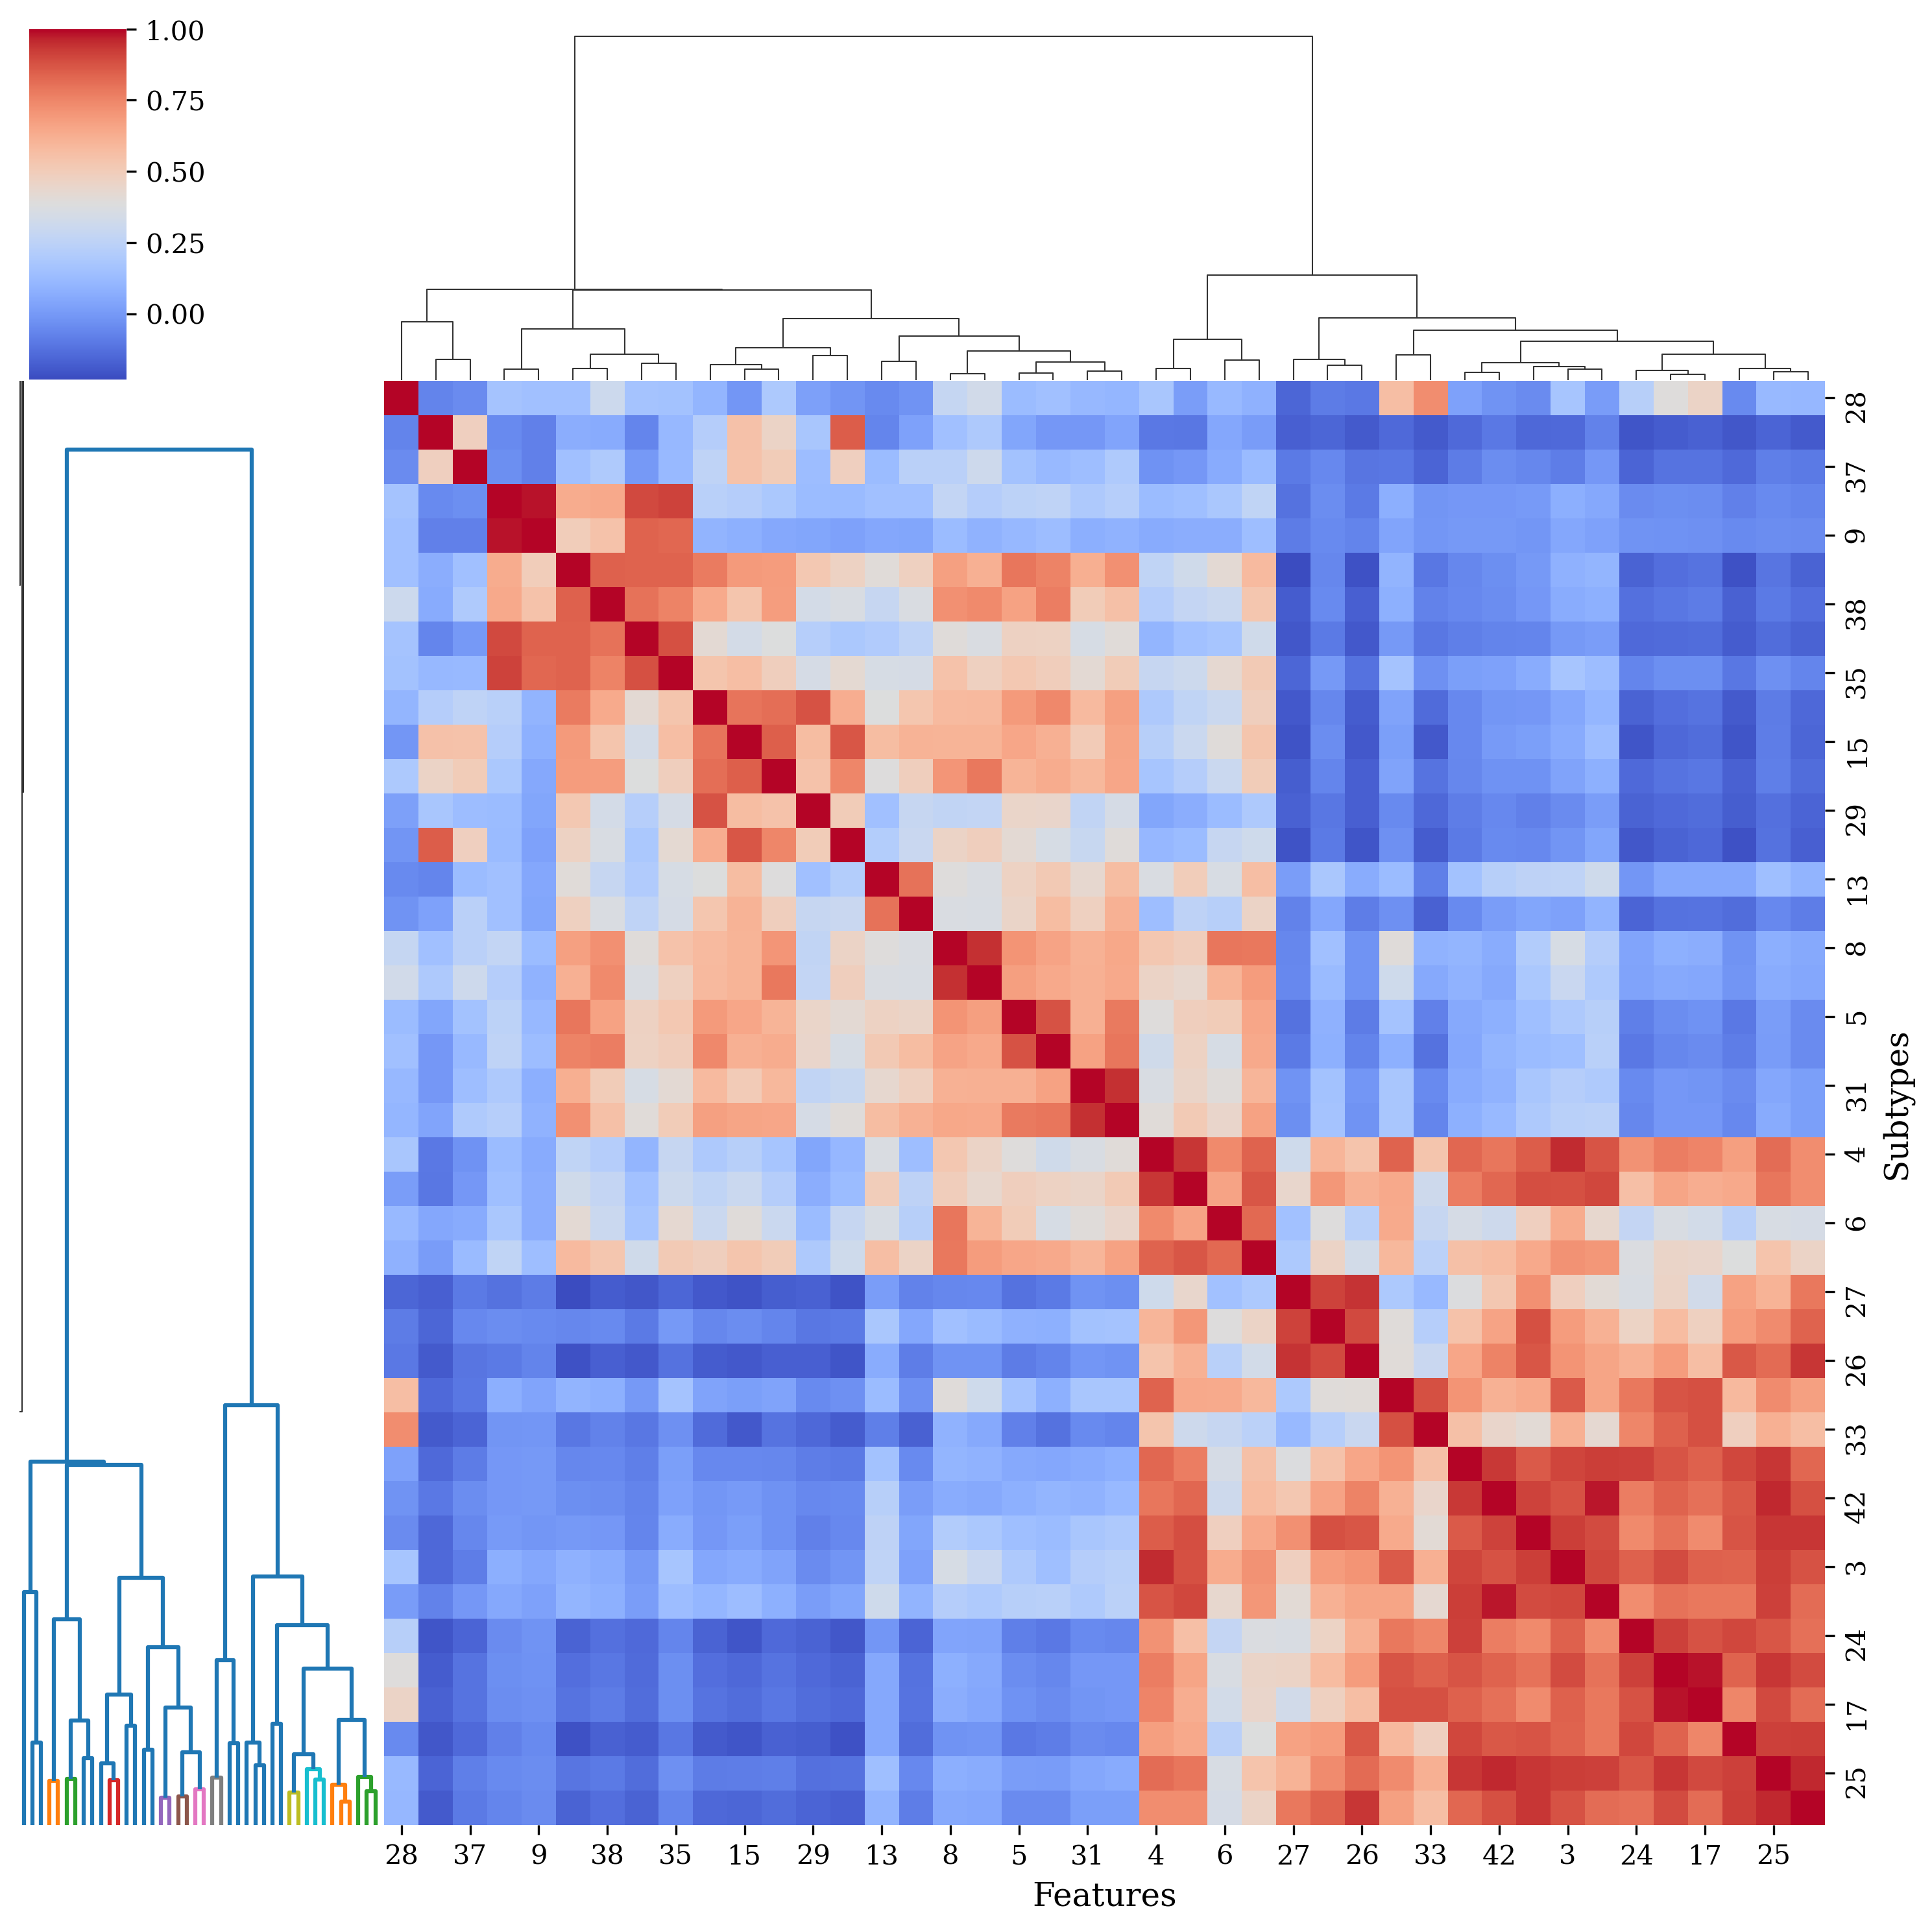

In [9]:
from scipy.cluster.hierarchy import linkage, dendrogram

mclust_subtype_mean_corr = mclust_subtype_mean.copy()
corr_matrix = mclust_subtype_mean_corr.T.corr()

# plt.figure(dpi=50)
# 使用 clustermap 自动绘制带层次聚类的热图
g = sns.clustermap(corr_matrix,
                   cmap='coolwarm',
                   method='ward',  # 聚类方法
                   metric='euclidean',  # 距离度量
                   figsize=(10, 10),
                   dendrogram_ratio=0.2,  # 树状图比例
                   cbar_pos=(0.02, 0.8, 0.05, 0.18))  # 调整色带位置

# 自定义美化参数
g.ax_heatmap.set_xlabel("Features", fontsize=12)
g.ax_heatmap.set_ylabel("Subtypes", fontsize=12)
g.ax_row_dendrogram.set_visible(True)  # 显示行树状图
g.ax_col_dendrogram.set_visible(True)  # 显示列树状图

# 手动添加树状图切割线示例（切割为3类）
dendro = linkage(corr_matrix, method='ward')
dendrogram(dendro, color_threshold=0.7, ax=g.ax_row_dendrogram)
plt.show()

### cell type percentage and roe

In [10]:
with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
type_order = STAGATE_params['type_order']
subtype_order = STAGATE_params['subtype_order']
column_order = [list(corr_matrix.index)[_] for _ in g.dendrogram_row.reordered_ind]

# type
mclust_type_counts = mclust_type_counts.loc[column_order, type_order]
mclust_type_mean = mclust_type_counts.div(mclust_type_counts.sum(axis=1), axis=0)

# subtype
mclust_subtype_counts = mclust_subtype_counts.loc[column_order, subtype_order]
mclust_subtype_mean = mclust_subtype_counts.div(mclust_subtype_counts.sum(axis=1), axis=0)

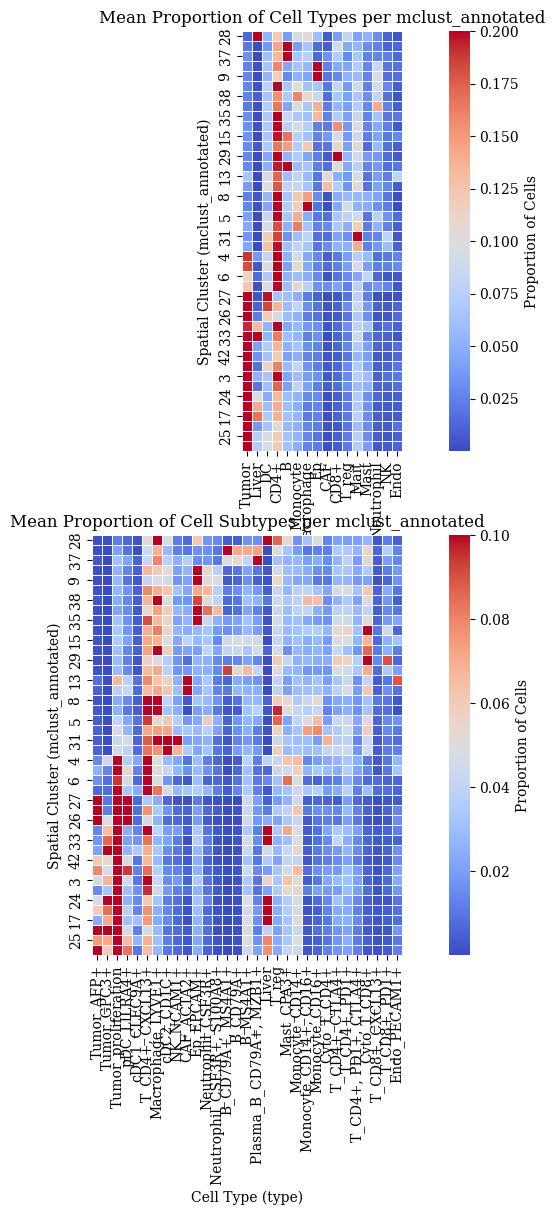

In [11]:
fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(12, 12), dpi=100)
# type
ax1 = axes[0]
sns.heatmap(mclust_type_mean, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, vmax=0.2, 
            cbar_kws={'label': 'Proportion of Cells'}, ax=ax1)
ax1.set_title('Mean Proportion of Cell Types per mclust_annotated')
ax1.set_xlabel('Cell Type (type)')
ax1.set_ylabel('Spatial Cluster (mclust_annotated)')

# subtype
ax2 = axes[1]
sns.heatmap(# annot=True, 
    mclust_subtype_mean, cmap='coolwarm', fmt='.2f', linewidths=0.5, square=True, vmax=0.1,
    cbar_kws={'label': 'Proportion of Cells'}, ax=ax2)
ax2.set_title('Mean Proportion of Cell Subtypes per mclust_annotated')
ax2.set_xlabel('Cell Type (type)')
ax2.set_ylabel('Spatial Cluster (mclust_annotated)')
# plt.savefig(tmp_output_path / 'mclust_annotated_type_subtype.pdf')
# plt.close()
plt.show()

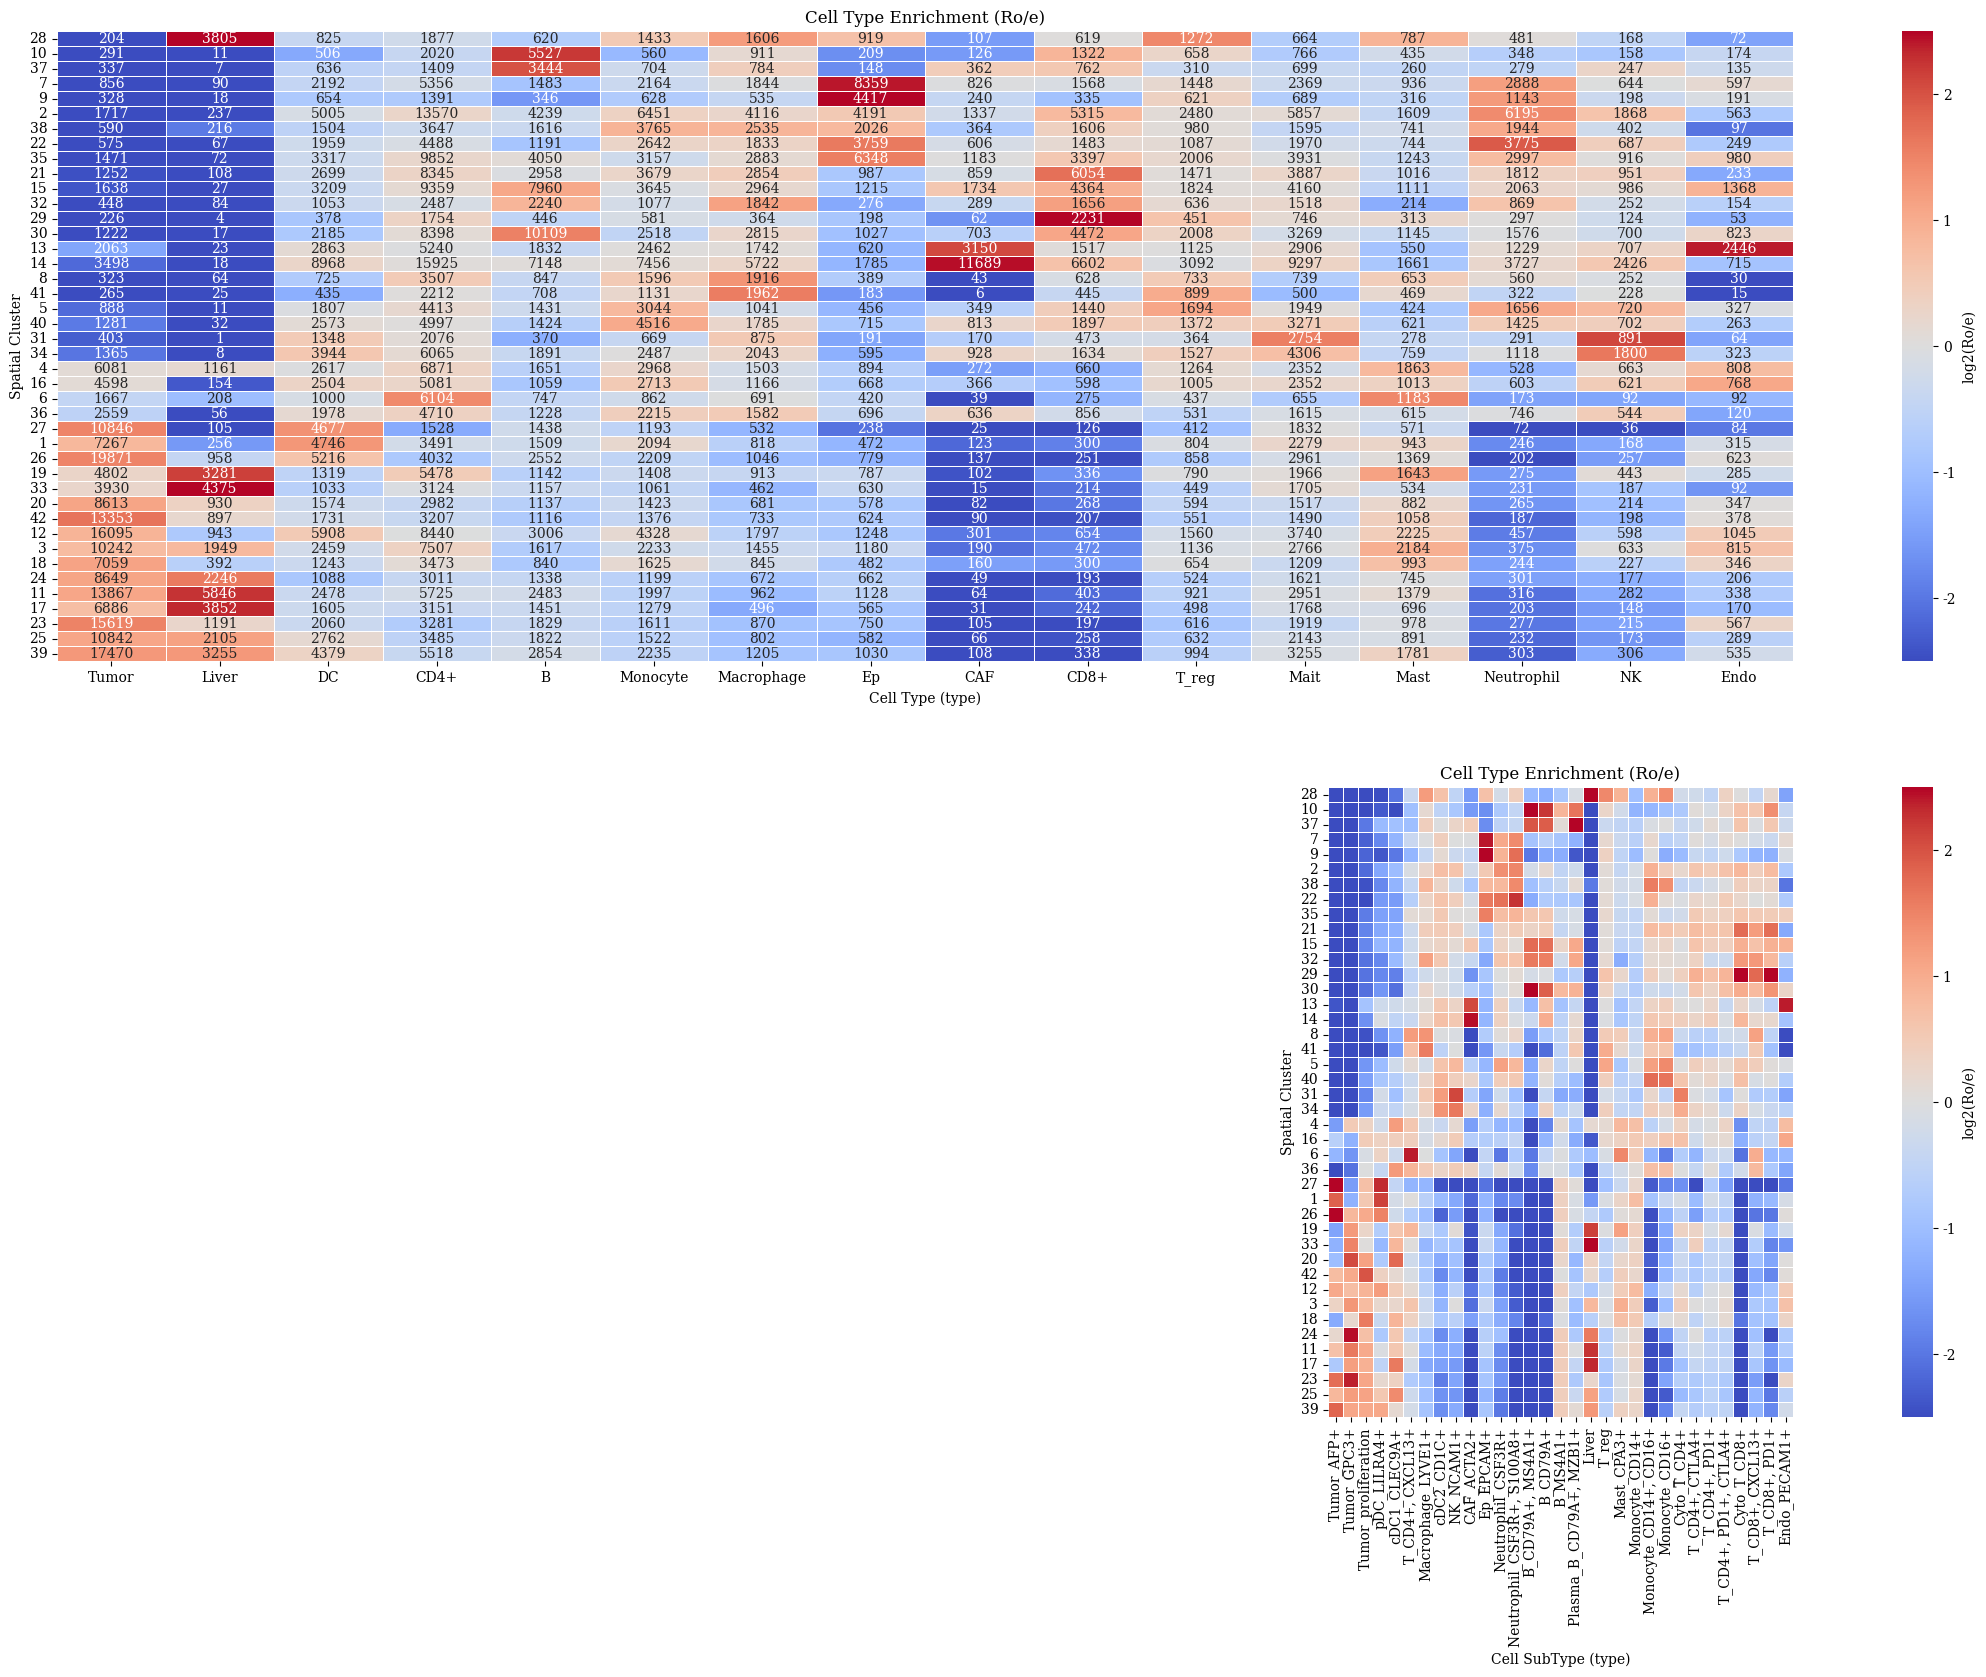

In [14]:
def roe_cal(df1, df2):
    # 提取 mclust_annotated 和 type 的观察值
    observed = pd.crosstab(df1, df2)

    # 计算期望值（基于全局比例）
    total_cells = observed.sum().sum()  # 总细胞数
    type_proportions = observed.sum(axis=0) / total_cells  # 每个 type 的全局比例
    mclust_totals = observed.sum(axis=1)  # 每个 mclust 的总细胞数

    # 计算期望值矩阵
    expected = pd.DataFrame(
        np.outer(mclust_totals, type_proportions),
        index=observed.index, columns=observed.columns)

    # 计算 Ro/e 并避免除以零
    roe = observed / expected.replace(0, 1e-10)
    return roe, expected, observed

fig, axes = plt.subplots(ncols=1, nrows=2, figsize=(28, 18), dpi=100)
ax1 = axes[0]
roe_type, expected_type, observed_type = roe_cal(adata.obs[key], adata.obs["type"])

roe_type = roe_type.loc[column_order, type_order]
observed_type = observed_type.loc[column_order, type_order]
sns.heatmap(
    np.log2(roe_type), cmap="coolwarm", center=0, # 以 log2(1)=0 为中心（无富集）
    annot=observed_type, # 标注原始观察值
    vmax=2.5, vmin=-2.5, fmt="d", # 观察值为整数
    linewidths=0.5, cbar_kws={"label": "log2(Ro/e)"}, ax=ax1)
ax1.set_title("Cell Type Enrichment (Ro/e)")
ax1.set_xlabel("Cell Type (type)")
ax1.set_ylabel("Spatial Cluster")

ax2 = axes[1]
roe_subtype, expected_subtype, observed_subtype = roe_cal(adata.obs[key], adata.obs["subtype"])
roe_subtype = roe_subtype.loc[column_order, subtype_order]
observed_subtype = observed_subtype.loc[column_order, subtype_order]
sns.heatmap(
    np.log2(roe_subtype), cmap="coolwarm", center=0, square=True, # 以 log2(1)=0 为中心（无富集）
    # annot=observed_subtype, # 标注原始观察值
    vmax=2.5, vmin=-2.5, fmt="d", # 观察值为整数
    linewidths=0.5, cbar_kws={"label": "log2(Ro/e)"}, ax=ax2)
ax2.set_title("Cell Type Enrichment (Ro/e)")
ax2.set_xlabel("Cell SubType (type)")
ax2.set_ylabel("Spatial Cluster")
# plt.savefig(tmp_output_path / 'mclust_annotated_type_subtype_ROE.pdf')
# plt.close()
plt.show()

### define region based on cell composition and gene expression

In [ ]:
with open(os.path.join(analysis_dir / "STAGATE_analysis_params.yaml"), "r") as f:
    STAGATE_params = yaml.load(f, Loader=yaml.FullLoader)
STAGATE_annotate = STAGATE_params[f'STAGATE_{key}_annotate']
pprint(STAGATE_annotate, sort_dicts=False)
map_dict = {str(mclust): str(num+1) for num, (key, mclust_list) in enumerate(STAGATE_annotate.items()) for mclust in mclust_list}
adata.obs['mclust_annotated'] = adata.obs[key].astype(str).map(map_dict).astype(str)